In [83]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.stats import poisson, halfnorm
from scipy.ndimage import gaussian_filter
from copy import copy
import multiprocessing 
import pandas as pd
from matplotlib import rc, cm
from itertools import product
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits.mplot3d import Axes3D

from data_generation import generate_diffusion_trajectory, generate_random_walk_trajectory, generatePlaceFields1D, h
from data_analysis import estimate_place_fields
from helper_functions import resample
from parameter_estimation import fit_random_walk_model, fit_random_walk_model_no_boundaries, \
get_random_walk_likelihood, fit_random_walk_model_empirically, fit_q_empirically, \
fit_tau_empirically, fit_diffusion_model
from filtering_algorithms import diffusion_pf, random_walk_pf

nan = np.nan

rc('text', usetex=True)
rc('font', family='serif')

%load_ext autoreload
%autoreload 2

## Integrated Random Walk PF

Integrated random walk generative model with boundary conditions. 
$$\frac{dx}{dt} =  v$$
$$dv = -\frac{dt}\tau v + q dW_t$$
$$dW_t \sim \mathcal{N} (0, dt)$$
$$p(v_t|v_{t-1}) = \mathcal{N} ( v_t; v_{t-1} - \frac{dt}{\tau}v_{t-1}, q^2 \times dt )$$
$dt$ somewhere around $0.1-0.001$, test and check.

### Generate Artificial Data

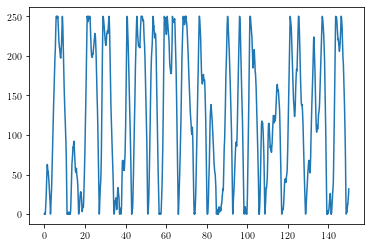

In [38]:
dt = 0.01
T = 150
t = np.arange(0,T,dt)
M = 10 # number of neurons
L = 250 # total length
dL = 0.1
P = 1000
Peff_min = 0.5

params = {
    "tau": 10,
    "q": 100,
    "dt": dt,
    "dL": dL,
    "T": T,
    "P": P,
    "Peff_min": Peff_min,
    "L": L
}

X, xaxis = generate_random_walk_trajectory(params, boundaries=True, round_data=False)
X_train, X_validation, X_test = np.split(X, [int(.6*len(X)), int(.8*len(X))])
params["xaxis"] = xaxis

plt.plot(t,X[:,0])
plt.show()

In [39]:
f = generatePlaceFields1D(M,xaxis,L)
params["f"] = f

H = h(X[:,0],f,xaxis,dL)
dN = np.random.poisson(H * dt)
spikes = dN.transpose()

spikes_train, spikes_validation, spikes_test = np.split(spikes, [int(.6*len(spikes)), int(.8*len(spikes))])

estimated_place_fields, smoothed_place_fields = estimate_place_fields(spikes_train, X_train[:,0], xaxis, dt)
params["estimated_place_fields"] = estimated_place_fields
params["smoothed_place_fields"] = smoothed_place_fields

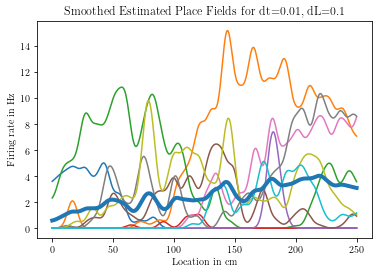

In [40]:
plt.plot(xaxis,np.transpose(smoothed_place_fields))
plt.plot(xaxis,np.sum(smoothed_place_fields,0)/M,linewidth=4)
plt.title("Smoothed Estimated Place Fields for dt={}, dL={}".format(dt, dL))
plt.ylabel("Firing rate in Hz")
plt.xlabel("Location in cm")
plt.show()

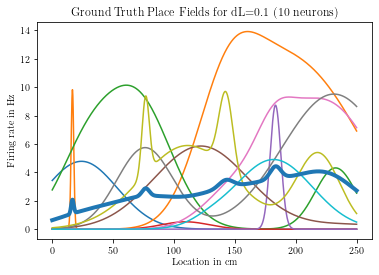

In [41]:
plt.plot(xaxis,np.transpose(f))
plt.plot(xaxis,np.sum(f,0)/M,linewidth=4)
plt.title("Ground Truth Place Fields for dL={} ({} neurons)".format(dL, M))
plt.ylabel("Firing rate in Hz")
plt.xlabel("Location in cm")
plt.show()

### Particle Filter

In [42]:
x_pf, w_pf = random_walk_pf(spikes, params)

/Users/kushagrasharma/.pyenv/versions/jupyter3/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide


In [43]:
mu = np.sum(x_pf[:,0,:] * w_pf, 1)
mean_validation_err = abs(mu[len(X_train):len(X_train)+len(X_validation)]-X_validation[:,0]).mean()
mean_test_err = abs(mu[len(X_train)+len(X_validation):]-X_test[:,0]).mean()

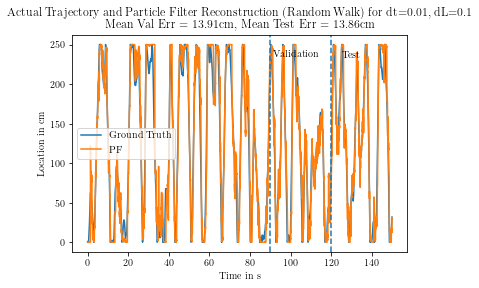

In [44]:
plt.plot(t,X[:,0])
plt.plot(t,mu)
plt.title("Actual Trajectory and Particle Filter Reconstruction (Random Walk) for dt={}, dL={}\n Mean Val Err = {:.2f}cm, Mean Test Err = {:.2f}cm".format(dt, dL, mean_validation_err, mean_test_err))
plt.legend(['Ground Truth', 'PF'])
plt.ylabel("Location in cm") 
plt.xlabel("Time in s")
plt.axvline(len(X_train) * dt, ls='--')
plt.axvline((len(X_train) + len(X_validation)) * dt, ls='--')
plt.figtext(0.59,0.8,"Validation")
plt.figtext(0.75,0.8,"Test")
plt.show()

In [9]:
# produces weighted histogram images
def histImage(x, bins, rang, w=0):
    image = np.zeros((x.shape[0],bins))
    
    if np.isscalar(w):
        for i in range(x.shape[0]):
            image[i,:] = np.histogram(x[i,:],bins,rang,density=True)[0]
    else:
        for i in range(x.shape[0]):
            image[i,:] = np.histogram(x[i,:],bins,rang,weights=w[i,:],density=True)[0]
        
    return image

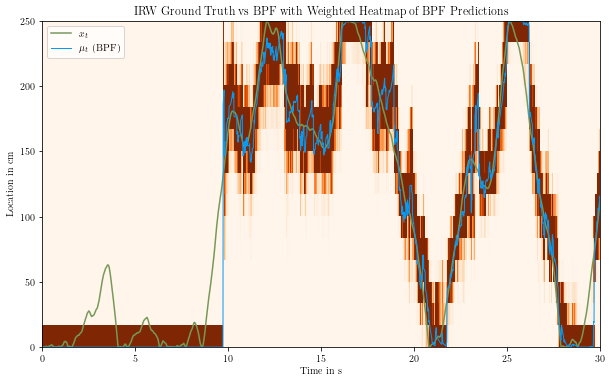

In [10]:
T_stop = 30

plotrange = [0,T_stop,0,L]

fig, (ax2) = plt.subplots(1,1,figsize=(10,6))



hist = np.transpose(histImage(x_pf[:,0,:],15,(-10,L),w=w_pf)) * 100
ax2.imshow(np.flipud(hist[:,:int(T_stop/dt)]), cmap='Oranges', interpolation='nearest', extent=[0,T_stop,0,L],aspect='auto',vmax=0.7)
ax2.plot(t[:int(T_stop/dt)],X[:int(T_stop/dt),0],color='xkcd:moss')
ax2.plot(t[:int(T_stop/dt)],np.average(x_pf[:,0,:],1,w_pf)[:int(T_stop/dt)], linewidth=1,color = 'xkcd:azure')
ax2.axis(plotrange)
ax2.legend(['hidden state','BPF'],fontsize=16)
ax2.legend([r'$x_t$',r'$\mu_t$ (BPF)'])
plt.title("IRW Ground Truth vs BPF with Weighted Heatmap of BPF Predictions")
plt.ylabel("Location in cm")
plt.xlabel("Time in s")

plt.show()

## Parameter search for IBM Model

## Test Parameter Estimation with and Without Boundaries

In [11]:
b_q = 0
b_tau = 0

nob_q = 0
nob_tau = 0
for i in range(100):
    true_tau = np.random.uniform(0, 25)
    true_q = np.random.uniform(5, 50)

    params["tau"] = true_tau
    params["q"] = true_q
    T = 500
    params["T"] = T
    t = np.arange(0,T,dt)
    L = 250
    params["L"] = 250

    X, xaxis = generate_random_walk_trajectory(params, boundaries=True, round_data=False)
    q_hat_nob, tau_hat_nob = fit_random_walk_model_no_boundaries(X, dt) 
    q_hat, tau_hat = fit_random_walk_model(X, dt, use_velocity=False)
    if abs(q_hat_nob-true_q) < abs(q_hat-true_q):
        nob_q += 1
    else:
        b_q += 1
    if abs(tau_hat_nob-true_tau) < abs(tau_hat-true_tau):
        nob_tau += 1
    else:
        b_tau += 1

/Users/kushagrasharma/coding/drugo-lab/place-cell-reconstruction/parameter_estimation.py:61: RuntimeWarning: invalid value encountered in greater
  pos[pos>upper_cutoff] = nan


## Testing IBM on IBM Data

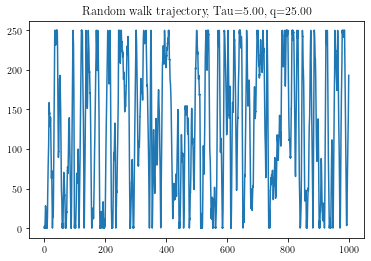

In [63]:
true_tau = 5
true_q = 25

params["tau"] = true_tau
params["q"] = true_q
T = 1000
params["T"] = T
t = np.arange(0,T,dt)
params["t"] = t
L = 250
params["L"] = 250

X, xaxis = generate_random_walk_trajectory(params, boundaries=True, round_data=False)
X_train, X_validation, X_test = np.split(X, [int(.6*len(X)), int(.8*len(X))])
params["xaxis"] = xaxis

plt.title("Random walk trajectory, Tau={:.2f}, q={:.2f}".format(true_tau, true_q))
plt.plot(t,X[:,0])

In [64]:
_, _, likelihoods = fit_random_walk_model_empirically(X_train, dt, samples=100)

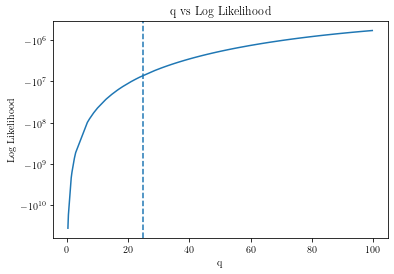

In [65]:
q_likelihoods = likelihoods.groupby('q').mean().sort_values('q')
plt.plot(q_likelihoods.index, q_likelihoods.likelihood)
plt.yscale('symlog')
plt.title("q vs Log Likelihood")
plt.xlabel("q")
plt.ylabel("Log Likelihood")
plt.axvline(x=true_q, ls='--')
plt.show()

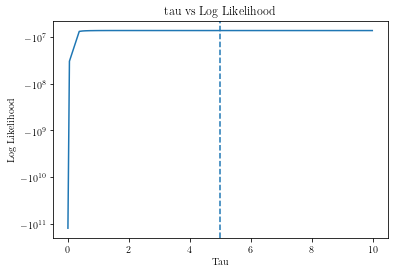

In [66]:
tau_likelihoods = likelihoods.groupby('tau').mean().sort_values('tau')
plt.plot(tau_likelihoods.index, tau_likelihoods.likelihood)
plt.yscale('symlog')
plt.title("tau vs Log Likelihood")
plt.xlabel("Tau")
plt.ylabel("Log Likelihood")
plt.axvline(x=true_tau, ls='--')
plt.show()

In [67]:
q_hat, tau_hat = fit_random_walk_model_no_boundaries(X_train, dt) 
params["q"] = q_hat
params["tau"] = tau_hat
print(q_hat, tau_hat)

25.005622148648765 7.650564943672253


/Users/kushagrasharma/coding/drugo-lab/place-cell-reconstruction/parameter_estimation.py:61: RuntimeWarning: invalid value encountered in greater
  pos[pos>upper_cutoff] = nan


## Generating Place Fields + Running PF

In [68]:
f = generatePlaceFields1D(M,xaxis,L)
params["f"] = f

H = h(X[:,0],f,xaxis,dL)
dN = np.random.poisson(H * dt)
spikes = dN.transpose()

spikes_train, spikes_validation, spikes_test = np.split(spikes, [int(.6*len(spikes)), int(.8*len(spikes))])
estimated_place_fields, smoothed_place_fields = estimate_place_fields(spikes_train, X_train[:,0], xaxis, dt)
params["estimated_place_fields"] = estimated_place_fields
params["smoothed_place_fields"] = smoothed_place_fields

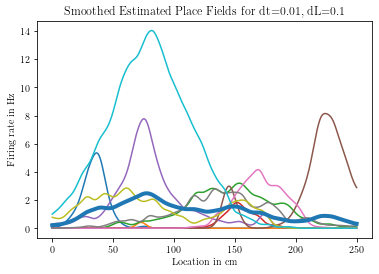

In [69]:
plt.plot(xaxis,np.transpose(smoothed_place_fields))
plt.plot(xaxis,np.sum(smoothed_place_fields,0)/M,linewidth=4)
plt.title("Smoothed Estimated Place Fields for dt={}, dL={}".format(dt, dL))
plt.ylabel("Firing rate in Hz")
plt.xlabel("Location in cm")
plt.show()

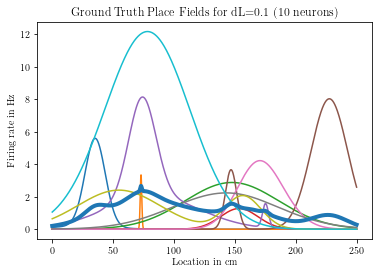

In [70]:
plt.plot(xaxis,np.transpose(f))
plt.plot(xaxis,np.sum(f,0)/M,linewidth=4)
plt.title("Ground Truth Place Fields for dL={} ({} neurons)".format(dL, M))
plt.ylabel("Firing rate in Hz")
plt.xlabel("Location in cm")
plt.show()

In [71]:
x_pf, w_pf = random_walk_pf(spikes, params)

/Users/kushagrasharma/.pyenv/versions/jupyter3/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide


In [72]:
mu = np.sum(x_pf[:,0,:] * w_pf, 1)
mean_validation_err = abs(mu[len(X_train):len(X_train)+len(X_validation)]-X_validation[:,0]).mean()
mean_test_err = abs(mu[len(X_train)+len(X_validation):]-X_test[:,0]).mean()

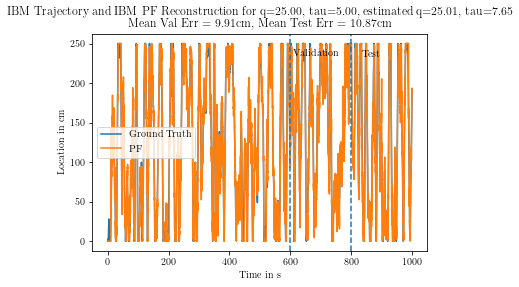

In [73]:
plt.plot(t,X[:,0])
plt.plot(t,mu)
plt.title("IBM Trajectory and IBM PF Reconstruction for q={:.2f}, tau={:.2f}, estimated q={:.2f}, tau={:.2f}\n Mean Val Err = {:.2f}cm, Mean Test Err = {:.2f}cm".format(true_q, true_tau, q_hat, tau_hat, mean_validation_err, mean_test_err))
plt.legend(['Ground Truth', 'PF'])
plt.ylabel("Location in cm") 
plt.xlabel("Time in s")
plt.axvline(len(X_train) * dt, ls='--')
plt.axvline((len(X_train) + len(X_validation)) * dt, ls='--')
plt.figtext(0.59,0.8,"Validation")
plt.figtext(0.75,0.8,"Test")
plt.show()

## Testing Diffusion on IBM Data

In [76]:
sigma_hat = fit_diffusion_model(X_train, params["dt"])
params["sigma"] = sigma_hat

In [77]:
x_pf, w_pf = diffusion_pf(spikes, params)

/Users/kushagrasharma/coding/drugo-lab/place-cell-reconstruction/filtering_algorithms.py:38: RuntimeWarning: invalid value encountered in true_divide
  w[i] /= np.sum(w[i])


In [79]:
mu = np.sum(x_pf * w_pf, 1)
mean_validation_err = abs(mu[len(X_train):len(X_train)+len(X_validation)]-X_validation[:,0]).mean()
mean_test_err = abs(mu[len(X_train)+len(X_validation):]-X_test[:,0]).mean()

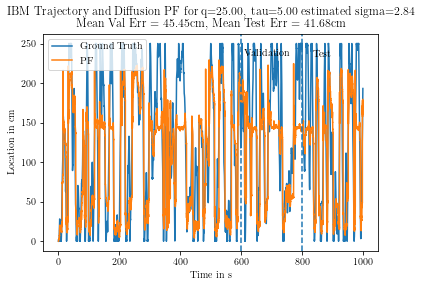

In [80]:
plt.plot(t,X[:,0])
plt.plot(t,mu)
plt.title("IBM Trajectory and Diffusion PF for q={:.2f}, tau={:.2f} estimated sigma={:.2f}\n Mean Val Err = {:.2f}cm, Mean Test Err = {:.2f}cm".format(true_q, true_tau, sigma_hat, mean_validation_err, mean_test_err))
plt.legend(['Ground Truth', 'PF'])
plt.ylabel("Location in cm") 
plt.xlabel("Time in s")
plt.axvline(len(X_train) * dt, ls='--')
plt.axvline((len(X_train) + len(X_validation)) * dt, ls='--')
plt.figtext(0.59,0.8,"Validation")
plt.figtext(0.75,0.8,"Test")
plt.show()

## Model Complexity

In [85]:
params["initial_condition"] = X_validation[0,0]
params["T"] = len(X_validation) * dt
t = np.arange(0,params["T"],dt)
params["t"] = t

In [ ]:
params["P"] = 50000
x_diffusion_pf, w_diffusion_pf = diffusion_pf(spikes, params)

x_ibm_pf, w_ibm_pf = random_walk_pf(spikes, params)

In [ ]:
particle_nums = np.sort(np.random.choice(np.arange(1, 50001), replace=False, size=1000))
diffusion_error = []
ibm_error = []
for p_num in particle_nums:
    idx = np.sort(np.random.choice(np.arange(0, 50000), replace=False, size=p_num))
    mu_diffusion = np.sum(x_diffusion_pf[:,idx] * w_diffusion_pf[:,idx], 1)
    
    mu_ibm = np.sum(x_pf[:,0,idx] * w_pf[:,idx], 1)
                                         
    diffusion_error.append(abs(mu_diffusion - X_validation[:,0]).mean())
    ibm_error.append(abs(mu_ibm - X_validation[:,0]).mean())                      